In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from DSS_analyzer_Mariner import Data1D_GAUGE, Data1D_PumpingCurve
datapath = "./"
gauge_data_folder = datapath + "s_well/gauge_data/"
gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE(gauge_data_folder + f"gauge6_data_swell.npz")
# Plot the gauge data
from DSS_analyzer_Mariner import Data1D_PumpingCurve
pumping_curve_filepath = datapath + f"prod/pumping_curve/pumping_curve_stage7.npz"
pumping_curve = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath)

# Crop the pressure gauge data,
start_time = pumping_curve.get_start_time()
end_time = pumping_curve.get_end_time()
gauge_dataframe.crop(start_time, end_time)

gauge_md_index = np.array([265, 520,  789, 1043, 1312, 1567])
frac_hit_index = np.array([589, 830])

In [3]:
# Interpolate the gauge data for any time point, the function would return the interpolated value
from scipy.interpolate import interp1d
def interpolate_gauge_data(time):
    gauge_data = gauge_dataframe.data
    gauge_taxis = gauge_dataframe.calculate_time()
    gauge_interpolator = interp1d(gauge_taxis * 3600, gauge_data, kind='linear')
    return gauge_interpolator(time)

In [5]:
# Simulator parameters
nx = 5000
# nx = 1800
total_time = 13000
d = 140 * np.ones(nx)
dx = 1
x = np.arange(0, nx*dx, dx)
x = x - nx * dx / 2 # make the center of the domain as 0
u_snapshot = [] # store the snapshot of u
u_current = np.zeros(nx)
t = list([0]) # store the time points
dt = 0
dt_init = 10.0

In [6]:
# Load the pumping curve data at next stage
pumping_curve_filepath = datapath + f"prod/pumping_curve/pumping_curve_stage8.npz"
pumping_curve = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath)

In [7]:
end_time_full = pumping_curve.get_end_time()

In [8]:
print("The total time of 2 stages is", (end_time_full - start_time).total_seconds(), "sec")

The total time of 2 stages is 36898.0 sec


# Phase 1

## simulator

In [9]:
# Simulator
def build_matrix_phase1(dt):
    alpha = d * dt / dx**2
    
    A = np.zeros((nx, nx))
    
    for i in range(1, nx-1):
        A[i, i-1] = -alpha[i]
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i+1] = -alpha[i]
    
    A[0, 0] = 1
    A[-1, -1] = 1
    A[0, 1] = -1
    A[-1, -2] = -1
    
# Simulator
def build_matrix_phase1(dt):
    alpha = d * dt / dx**2
    
    A = np.zeros((nx, nx))
    
    for i in range(1, nx-1):
        A[i, i-1] = -alpha[i]
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i+1] = -alpha[i]
    
    A[0, 0] = 1
    A[-1, -1] = 1
    A[0, 1] = -1
    A[-1, -2] = -1
    
    # Source term
    phase1_frac_hit_index = int(np.where(x == frac_hit_index[0])[0])
    A[phase1_frac_hit_index, :] = 0
    A[phase1_frac_hit_index, phase1_frac_hit_index] = 1
    
    return A

def build_rhs_phase1(u_current, t):
    rhs = u_current.copy()
    rhs[0] = 0
    rhs[-1] = 0
    # Source term.
    phase1_frac_hit_index = int(np.where(x == frac_hit_index[0])[0])
    rhs[phase1_frac_hit_index] = interpolate_gauge_data(t)
    # print(f"Time: {t}, Source: {interpolate_gauge_data(t)}") # debug info
    return rhs

In [10]:
# Create snapshot
u_current = gauge_dataframe.data[0] * np.ones_like(u_current) # initial condition
u_snapshot.append(u_current.copy())

In [11]:
# full step
def full_step_phase1(u_current, dt, t):
    A = build_matrix_phase1(dt)
    rhs = build_rhs_phase1(u_current, t)
    return np.linalg.solve(A, rhs)

# half step
def half_step_phase1(u_current, dt, t):
    dt_half = dt / 2
    A_half = build_matrix_phase1(dt_half)
    rhs_half = build_rhs_phase1(u_current, t)
    u_middle = np.linalg.solve(A_half, rhs_half)
    
    b_half = build_rhs_phase1(u_middle, t)
    u_final = np.linalg.solve(A_half, b_half)
    
    return u_final

In [12]:
# Time sampling optimizer
def adjust_dt(dt_current, error, tol=1e-3):
    safety_factor = 0.9
    p = 2
    
    dt_new = safety_factor * dt_current * (tol / max(error, 1e-16))**(1/(p+1))
    
    dt_new = min(2.0 * dt_init, max(0.5 * dt_current, dt_new))
    
    return dt_new

In [13]:
# test the full step
dt = dt_init

u_current = full_step_phase1(u_current, dt, t[-1])
u_snapshot.append(u_current.copy())
t.append(t[-1] + dt)

## Simulation

In [14]:
while t[-1] < total_time: # time loop
    print("dt = ", dt)
    # calculate the full step
    u_current = full_step_phase1(u_current, dt, t[-1])
    
    # calculate the half step
    u_current_half = half_step_phase1(u_current, dt, t[-1])
    
    # calculate the error
    error = np.linalg.norm(u_current_half - u_current) / np.linalg.norm(u_current)
    # print(f"Time: {t[-1]}, Error: {error}")
    # adjust the time step
    dt = adjust_dt(dt, error)
    
    if error <= 1e-3:
        # store the snapshot if the error is small enough.
        u_snapshot.append(u_current.copy())
        t.append(t[-1] + dt)
        
        # update the time step
        dt = min(dt, 10)
    else:
        # the error is too large, reduce the time step. Don't store the snapshot.
        dt = max(0.5 * dt, 0.5)
    
    # store the snapshot
    u_snapshot.append(u_current.copy())
    print(f"Time: {t[-1]}, Error: {error:.6f}")
    t.append(t[-1] + dt)

dt =  10.0
Time: 30.0, Error: 0.000001
dt =  10
Time: 60.0, Error: 0.000003
dt =  10
Time: 90.0, Error: 0.000005
dt =  10
Time: 120.0, Error: 0.000006
dt =  10
Time: 150.0, Error: 0.000007
dt =  10
Time: 180.0, Error: 0.000005
dt =  10
Time: 210.0, Error: 0.000005
dt =  10
Time: 240.0, Error: 0.000017
dt =  10
Time: 270.0, Error: 0.000029
dt =  10
Time: 300.0, Error: 0.000037
dt =  10
Time: 330.0, Error: 0.000041
dt =  10
Time: 360.0, Error: 0.000044
dt =  10
Time: 390.0, Error: 0.000045
dt =  10
Time: 420.0, Error: 0.000046
dt =  10
Time: 450.0, Error: 0.000047
dt =  10
Time: 480.0, Error: 0.000048
dt =  10
Time: 510.0, Error: 0.000048
dt =  10
Time: 540.0, Error: 0.000048
dt =  10
Time: 570.0, Error: 0.000048
dt =  10
Time: 600.0, Error: 0.000048
dt =  10
Time: 630.0, Error: 0.000048
dt =  10
Time: 660.0, Error: 0.000048
dt =  10
Time: 690.0, Error: 0.000049
dt =  10
Time: 720.0, Error: 0.000051
dt =  10
Time: 750.0, Error: 0.000052
dt =  10
Time: 780.0, Error: 0.000052
dt =  10
Time

# Phase 2 (stage 1 - stage 2)

In [15]:
total_time_interval = 3000 # I define the time in this phase

## Simulator

In [16]:
# Simulator
def build_matrix_phase2(dt):
    alpha = d * dt / dx**2
    
    A = np.zeros((nx, nx))
    
    for i in range(1, nx-1):
        A[i, i-1] = -alpha[i]
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i+1] = -alpha[i]
    
    A[0, 0] = 1
    A[-1, -1] = 1
    A[0, 1] = -1
    A[-1, -2] = -1
    
    # Source term: there is no source term in phase 2.
    return A

def build_rhs_phase2(u_current, t):
    rhs = u_current.copy()
    rhs[0] = 0
    rhs[-1] = 0
    # Source term. There is no source term in phase 2.
    return rhs

# full step
def full_step_phase2(u_current, dt, t):
    A = build_matrix_phase2(dt)
    rhs = build_rhs_phase2(u_current, t)
    return np.linalg.solve(A, rhs)

# half step
def half_step_phase2(u_current, dt, t):
    dt_half = dt / 2
    A_half = build_matrix_phase2(dt_half)
    rhs_half = build_rhs_phase2(u_current, t)
    u_middle = np.linalg.solve(A_half, rhs_half)
    
    b_half = build_rhs_phase2(u_middle, t)
    u_final = np.linalg.solve(A_half, b_half)
    
    return u_final

In [18]:
# In this case, I'll implement the first case: release the pressure, change the permeability. 
def pressure_diffusion_phase2(u_init, d):
    """
    A simplified wrapper function for performing a specific period of numerical simulation,
    mainly focusing on testing how different 'd' (diffusivity/permeability arrays) affect the results.
    
    Parameters
    ----------
    u_init : numpy.ndarray
        The initial field (e.g., pressure field).
    d : numpy.ndarray
        The diffusivity (or permeability) array related to the diffusion process.
        
    Returns
    ----------
    result_snapshots : numpy.ndarray
        An array of shape (N, ...) containing the solutions at various time steps.
    """
    
    # ========== 1. Preset internal parameters (modify if needed) ==========
    # Example index of the fracture hit
    
    # Total time interval for this simulation phase
    total_time_interval = 3000.0
    
    # Initial time step
    dt = 1.0
    
    # Time sequence, starting from 0
    t = [0.0]
    
    # Error threshold
    error_threshold = 1e-3
    
    # Max and min time step
    dt_max = 10.0
    dt_min = 0.5
    
    # ========== 2. Initialization ==========
    # Copy the initial field to avoid modifying the input directly
    u_current = u_init.copy()
    
    # Store snapshots of the solution
    u_snapshot = [u_current.copy()]
    
    # Calculate the end time for this simulation stage
    total_time = t[-1] + total_time_interval
    
    # ========== 3. Time-stepping loop ==========
    while t[-1] < total_time:
        print("dt =", dt)
        
        # Call the full-step and half-step functions (define them externally)
        u_full = full_step_phase2(u_current, dt, t[-1])
        u_half = half_step_phase2(u_current, dt, t[-1])
        
        # Compute the error
        error = np.linalg.norm(u_half - u_current) / np.linalg.norm(u_current)
        
        # Adjust the time step (define this function externally as well)
        dt_new = adjust_dt(dt, error)
        
        if error <= error_threshold:
            # Error is small enough, accept this step
            u_current = u_full.copy()
            u_snapshot.append(u_current.copy())
            t.append(t[-1] + dt)
            dt = min(dt_new, dt_max)
        else:
            # Error is too large, reduce dt and retry
            dt = max(0.5 * dt_new, dt_min)
        
        # Print current time step info
        print(f"Time: {t[-1]}, Error: {error:.6f}")
        
        # You could choose whether or not to store a snapshot here every iteration
        u_snapshot.append(u_current.copy())
        t.append(t[-1] + dt)

    # ========== 4. Convert snapshots to an array and return ==========
    result_snapshots = np.array(u_snapshot)
    t = np.array(t)
    return result_snapshots, t

In [19]:
# # This block is for test
# phase2_snapshot = []
# phase2_taxis = []
# phase1_frac_hit_index = int(np.where(x == frac_hit_index[0])[0])
# # change the D
# d[phase1_frac_hit_index] = d[phase1_frac_hit_index] * 0.001 # I change the diffusivity here to 0.001 * ORIGINAL
# phase2_snapshot, taxis_phase2 = pressure_diffusion_phase2(u_snapshot[-1], d)

dt = 1.0
Time: 1.0, Error: 0.000004
dt = 5.799482579901331
Time: 12.598965159802662, Error: 0.000022
dt = 10.0
Time: 32.59896515980266, Error: 0.000037
dt = 10.0
Time: 52.59896515980266, Error: 0.000038
dt = 10.0
Time: 72.59896515980266, Error: 0.000038
dt = 10.0
Time: 92.59896515980266, Error: 0.000038
dt = 10.0
Time: 112.59896515980266, Error: 0.000037
dt = 10.0
Time: 132.59896515980267, Error: 0.000037
dt = 10.0
Time: 152.59896515980267, Error: 0.000037
dt = 10.0
Time: 172.59896515980267, Error: 0.000037
dt = 10.0
Time: 192.59896515980267, Error: 0.000037
dt = 10.0
Time: 212.59896515980267, Error: 0.000037
dt = 10.0
Time: 232.59896515980267, Error: 0.000037
dt = 10.0
Time: 252.59896515980267, Error: 0.000037
dt = 10.0
Time: 272.5989651598027, Error: 0.000037
dt = 10.0
Time: 292.5989651598027, Error: 0.000037
dt = 10.0
Time: 312.5989651598027, Error: 0.000037
dt = 10.0
Time: 332.5989651598027, Error: 0.000036
dt = 10.0
Time: 352.5989651598027, Error: 0.000036
dt = 10.0
Time: 372.5989

In [44]:
# print(np.shape(u_snapshot))
# print(np.shape(phase2_snapshot))
# combined_snapshot = np.concatenate([u_snapshot, phase2_snapshot], axis=0)
# # Update phase 2 taxis and combine
# taxis_phase2 += t[-1]
# combined_taxis = np.concatenate([t, taxis_phase2])
# plt.figure()
# plt.imshow(combined_snapshot, aspect='auto', extent=[x[0], x[-1], taxis_phase2[-1], 0])
# plt.show()

In [44]:
# loc_ind = 3200
# plt.figure()
# plt.plot(combined_taxis, combined_snapshot[:, loc_ind])
# plt.title(f"Pressure change in stage 1 (and interval) at loc {x[loc_ind]:.2f} ft")
# plt.show()

In [45]:
# Create phase 2 snapshot, (nx, nt, len(diff_change_ratio))
diff_change_ratio = np.array([0.5, 0.3, 0.1, 0.05, 0.01, 0.001])
phase2_snapshots = []
phase2_taxis = []
for diff_ratio in diff_change_ratio:
    phase1_frac_hit_index = int(np.where(x == frac_hit_index[0])[0])
    d[phase1_frac_hit_index] = diff_ratio * d[phase1_frac_hit_index] # change the permeability at the fracture hit
    phase2_snapshot, taxis_phase2 = pressure_diffusion_phase2(u_snapshot[-1], d)
    phase2_snapshots.append(phase2_snapshot)
    phase2_taxis.append(taxis_phase2)

dt = 1.0
Time: 1.0, Error: 0.000004
dt = 5.814779961132049
Time: 12.629559922264098, Error: 0.000021
dt = 10.0
Time: 32.6295599222641, Error: 0.000036
dt = 10.0
Time: 52.6295599222641, Error: 0.000036
dt = 10.0
Time: 72.6295599222641, Error: 0.000035
dt = 10.0
Time: 92.6295599222641, Error: 0.000035
dt = 10.0
Time: 112.6295599222641, Error: 0.000035
dt = 10.0
Time: 132.6295599222641, Error: 0.000035
dt = 10.0
Time: 152.6295599222641, Error: 0.000035
dt = 10.0
Time: 172.6295599222641, Error: 0.000034
dt = 10.0
Time: 192.6295599222641, Error: 0.000034
dt = 10.0
Time: 212.6295599222641, Error: 0.000034
dt = 10.0
Time: 232.6295599222641, Error: 0.000034
dt = 10.0
Time: 252.6295599222641, Error: 0.000034
dt = 10.0
Time: 272.6295599222641, Error: 0.000034
dt = 10.0
Time: 292.6295599222641, Error: 0.000034
dt = 10.0
Time: 312.6295599222641, Error: 0.000033
dt = 10.0
Time: 332.6295599222641, Error: 0.000033
dt = 10.0
Time: 352.6295599222641, Error: 0.000033
dt = 10.0
Time: 372.6295599222641, E

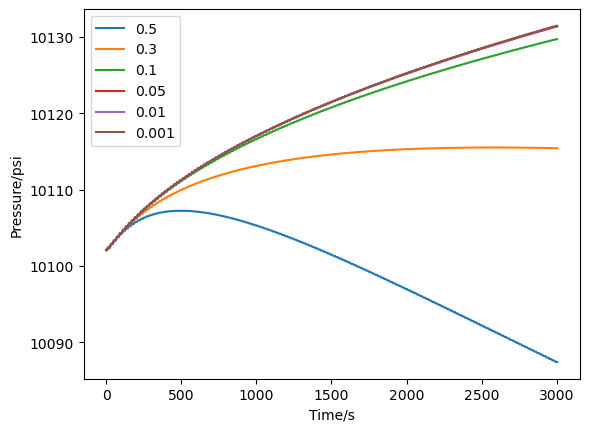

In [57]:
# Compare the result
loc_ind = 3300
plt.figure()
for iter in range(len(phase2_taxis)):
    plt.plot(phase2_taxis[iter], phase2_snapshots[iter][:, loc_ind], label=f"{diff_change_ratio[iter]}")
plt.xlabel("Time/s")
plt.ylabel("Pressure/psi")
plt.legend()
plt.show()

# Phase 3
## Add simulator

In [75]:
total_time_stage2 = 20898
total_time = 36898

In [76]:
# Simulator for phase 3. 
def build_matrix_phase3(dt):
    alpha = d * dt / dx**2
    
    A = np.zeros((nx, nx))
    
    for i in range(1, nx-1):
        A[i, i-1] = -alpha[i]
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i+1] = -alpha[i]
    
    A[0, 0] = 1
    A[-1, -1] = 1
    A[0, 1] = -1
    A[-1, -2] = -1
    
# Simulator
def build_matrix_phase3(dt):
    alpha = d * dt / dx**2
    
    A = np.zeros((nx, nx))
    
    for i in range(1, nx-1):
        A[i, i-1] = -alpha[i]
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i+1] = -alpha[i]
    
    A[0, 0] = 1
    A[-1, -1] = 1
    A[0, 1] = -1
    A[-1, -2] = -1
    
    # Source term
    phase3_frac_hit_index = int(np.where(x == frac_hit_index[1])[0])
    A[phase3_frac_hit_index, :] = 0
    A[phase3_frac_hit_index, phase3_frac_hit_index] = 1
    
    return A

def build_rhs_phase3(u_current, t):
    rhs = u_current.copy()
    rhs[0] = 0
    rhs[-1] = 0
    # Source term.
    phase3_frac_hit_index = int(np.where(x == frac_hit_index[1])[0])
    rhs[phase3_frac_hit_index] = interpolate_gauge_data(t)
    # print(f"Time: {t}, Source: {interpolate_gauge_data(t)}") # debug info
    return rhs

In [77]:
def pressure_diffusion_phase3(u_init, d):
    """
    A modified version of the Phase 2 simulation function, demonstrating how to
    release pressure and change permeability in a specific region (e.g., frac_hit_index).
    
    Parameters
    ----------
    u_init : numpy.ndarray
        The initial field (e.g., pressure field).
    d : numpy.ndarray
        The diffusivity (or permeability) array related to the diffusion process.
        
    Returns
    ----------
    result_snapshots : numpy.ndarray
        An array of shape (N, ...) containing the solutions at various time steps.
    """
    
    # ========== 1. Preset internal parameters (modify if needed) ==========
    total_time_interval = total_time_stage2 # Longer total time to simulate pressure release
    dt = 1.0                     # Initial time step
    t = [0.0]                    # Start time
    error_threshold = 1e-3       # Error threshold
    dt_max = 10.0                # Max allowable time step
    dt_min = 0.5                 # Min allowable time step
    
    # ========== 2. Initialization ==========
    # Copy the initial field to avoid modifying the input directly
    u_current = u_init.copy()
    
    # Store snapshots of the solution
    u_snapshot = [u_current.copy()]
    
    # Calculate the end time for this simulation stage
    total_time = t[-1] + total_time_interval
    
    # ========== 3. Time-stepping loop ==========
    while t[-1] < total_time:
        print("dt =", dt)
        
        # Full-step update (implement or import externally)
        u_full = full_step_phase2(u_current, dt, t[-1])
        
        # Half-step update (implement or import externally)
        u_half = half_step_phase2(u_current, dt, t[-1])
        
        # Compute the error
        error = np.linalg.norm(u_half - u_current) / np.linalg.norm(u_current)
        
        # Adjust the time step (implement or import externally)
        dt_new = adjust_dt(dt, error)
        
        if error <= error_threshold:
            # Accept this step if the error is small enough
            u_current = u_full.copy()
            u_snapshot.append(u_current.copy())
            t.append(t[-1] + dt)
            dt = min(dt_new, dt_max)
        else:
            # If the error is too large, reduce dt, skip snapshot storage
            dt = max(0.5 * dt_new, dt_min)
        
        # Print current time step info
        print(f"Time: {t[-1]}, Error: {error:.6f}")
        
        # Optional: store additional snapshot every iteration
        u_snapshot.append(u_current.copy())
        t.append(t[-1] + dt)

    # ========== 4. Convert snapshots to an array and return ==========
    result_snapshots = np.array(u_snapshot)
    # Also, return the time points for further analysis
    return result_snapshots, np.array(t)

In [ ]:
# Create phase 3 snapshot, (nx, nt, len(diff_change_ratio))
phase3_snapshots = []
phase3_taxis = []
flag = 0
for diff_ratio in diff_change_ratio:
    phase3_snapshot, taxis_phase3 = pressure_diffusion_phase3(phase2_snapshots[flag][-1], d)
    phase3_snapshots.append(phase3_snapshot)
    phase3_taxis.append(taxis_phase3)
    flag += 1

dt = 1.0
Time: 1.0, Error: 0.000002
dt = 6.725683709111816
Time: 14.451367418223631, Error: 0.000016
dt = 10.0
Time: 34.45136741822363, Error: 0.000023
dt = 10.0
Time: 54.45136741822363, Error: 0.000023
dt = 10.0
Time: 74.45136741822364, Error: 0.000023
dt = 10.0
Time: 94.45136741822364, Error: 0.000023
dt = 10.0
Time: 114.45136741822364, Error: 0.000023
dt = 10.0
Time: 134.45136741822364, Error: 0.000023
dt = 10.0
Time: 154.45136741822364, Error: 0.000022
dt = 10.0
Time: 174.45136741822364, Error: 0.000022
dt = 10.0
Time: 194.45136741822364, Error: 0.000022
dt = 10.0
Time: 214.45136741822364, Error: 0.000022
dt = 10.0
Time: 234.45136741822364, Error: 0.000022
dt = 10.0
Time: 254.45136741822364, Error: 0.000022
dt = 10.0
Time: 274.45136741822364, Error: 0.000022
dt = 10.0
Time: 294.45136741822364, Error: 0.000022
dt = 10.0
Time: 314.45136741822364, Error: 0.000022
dt = 10.0
Time: 334.45136741822364, Error: 0.000022
dt = 10.0
Time: 354.45136741822364, Error: 0.000022
dt = 10.0


In [ ]:
# Combine the result for different perm
for i in range(len(diff_change_ratio)):
    # Combine the result for different perm, phase 1 and 2
    tmp_snapshot = np.concatenate((u_snapshot, phase2_snapshots[i]), axis=0)
    # phase 2 and 3
    tmp_snapshot = np.concatenate((tmp_snapshot, phase3_snapshots[i]), axis=0)
    # Save the snapshot
    np.savez(f"diffusion_snapshot_{i}.npz", snapshot=tmp_snapshot, taxis=np.concatenate((t, phase2_taxis[i], phase3_taxis[i])))
    # save the taxis
    np.save(f"diffusion_taxis_{i}.npy", np.concatenate((t, phase2_taxis[i], phase3_taxis[i])))

In [ ]:
# Plot one of the results
plt.figure(figsize=(12, 6))
plt.imshow(tmp_snapshot, aspect='auto', cmap='jet', extent=[x[0], x[-1], 0, tmp_snapshot.shape[0]])
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("Time step")
plt.title("Pressure diffusion")
plt.show()